In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_path ='../../../Data/eumetnet'

In [2]:
preds = pd.read_feather(f'{data_path}/ESSD_benchmark_test_data_fcst.feather')

In [3]:
preds_columns = list(preds.columns.drop('t2m'))
preds_ = preds.set_index(preds_columns)
preds_

,,,,t2m
station_id,forecast_lead_time,forecast_reference_time,realization,
235,0,2017-01-01,0,279.987850
240,0,2017-01-01,0,275.759830
242,0,2017-01-01,0,280.025240
251,0,2017-01-01,0,279.786870
260,0,2017-01-01,0,274.157040
...,...,...,...,...
7460,20,2018-12-31,50,279.725698
11101,20,2018-12-31,50,281.003095
11105,20,2018-12-31,50,281.009157


In [4]:
# takes a few minutes
da_preds = preds_.to_xarray().t2m.astype('float32')

In [5]:
da_preds.coords

Coordinates:
  * station_id               (station_id) int64 235 240 242 ... 11308 11312
  * forecast_lead_time       (forecast_lead_time) int64 0 1 2 3 ... 17 18 19 20
  * forecast_reference_time  (forecast_reference_time) object '2017-01-01' .....
  * realization              (realization) object '0' '1' '2' ... '48' '49' '50'

In [6]:
da_preds.dtype

dtype('float32')

In [7]:
# add global attributes:
da_preds.attrs['institution'] = 'KIT'# Karlsruhe Institute of Technology 
da_preds.attrs['experiment'] = 'ESSD-benchmark'
da_preds.attrs['model'] = 'simple-NN'# in the paper this is referred to as DRN
da_preds.attrs['tier'] = 1
da_preds.attrs['version'] = 'v1.1'# 1
da_preds.attrs['dataset'] = 'hacky-phase'
da_preds.attrs['output'] = 'quantiles'

In [8]:
da_preds.attrs

{'institution': 'KIT',
 'experiment': 'ESSD-benchmark',
 'model': 'simple-NN',
 'tier': 1,
 'version': 'v1.1',
 'dataset': 'hacky-phase',
 'output': 'quantiles'}

In [9]:
file_name = f'{da_preds.tier}_{da_preds.experiment}_{da_preds.institution}_{da_preds.model}_{da_preds.version}'
file_name

'1_ESSD-benchmark_KIT_simple-NN_v1.1'

### compare with example output format

In [10]:
reference_out= xr.open_dataarray(f'{data_path}/1_ESSD-benchmark_RMIB_Pythie-MBM-AbsCRPSmin-commit21a29a9_seasonal-v1.0.nc')
reference_out

<xarray.DataArray 't2m' (station_id: 229, time: 730, step: 21, number: 51)>
[179039070 values with dtype=float32]
Coordinates: (12/13)
    model_altitude      (station_id) float32 ...
    model_land_usage    (station_id) int8 ...
    model_latitude      (station_id) float64 ...
    model_longitude     (station_id) float64 ...
  * number              (number) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    station_altitude    (station_id) float64 ...
    ...                  ...
    station_land_usage  (station_id) int8 ...
    station_latitude    (station_id) float64 ...
    station_longitude   (station_id) float64 ...
    station_name        (station_id) object ...
  * step                (step) timedelta64[ns] 0 days 00:00:00 ... 5 days 00:...
  * time                (time) datetime64[ns] 2017-01-01 ... 2018-12-31
Attributes:
    long_name:    2 metre temperature
    units:        K
    tier:         1
    experiment:   ESSD-benchmark
    institution:  RMIB
    model:        Pythie-MBM-AbsCRPSmin-commit21a29a9
    version:      seasonal-v1.0
    output:       members

In [11]:
correct_forecast_lead_time = reference_out.step.values
correct_forecast_reference_time = reference_out.time.values

### correct coords

In [12]:
da_preds.coords['forecast_lead_time'] = correct_forecast_lead_time
da_preds.coords['forecast_reference_time'] = correct_forecast_reference_time

In [13]:
da_preds.coords['realization'] = da_preds.coords['realization'].astype('int')

In [14]:
da_preds = da_preds.rename({'forecast_lead_time' : 'step', 'realization':'number', 
                            'forecast_reference_time' : 'time'})

In [15]:
da_preds

<xarray.DataArray 't2m' (station_id: 229, step: 21, time: 730, number: 51)>
array([[[[279.98785, 274.55704, 275.347  , ..., 284.1187 , 284.62872,
          285.41864],
         [278.42926, 272.9347 , 273.7339 , ..., 282.60864, 283.12463,
          283.92383],
         [278.51852, 273.07697, 273.86847, ..., 282.65756, 283.16858,
          283.96008],
         ...,
         [279.94183, 274.56085, 275.34357, ..., 284.0348 , 284.5401 ,
          285.32278],
         [280.15436, 274.7679 , 275.5514 , ..., 284.2515 , 284.75732,
          285.5408 ],
         [280.49408, 275.06897, 275.85806, ..., 284.62064, 285.1301 ,
          285.9192 ]],

        [[279.93573, 276.61224, 277.09567, ..., 282.46368, 282.7758 ,
          283.25922],
         [279.19696, 276.02133, 276.48325, ..., 281.61246, 281.91068,
          282.3726 ],
         [279.25543, 276.02655, 276.4962 , ..., 281.71146, 282.01465,
          282.4843 ],
...
         [266.32574, 260.62903, 261.45764, ..., 270.65887, 271.19385,
          272.02246],
         [264.4048 , 258.37018, 259.24792, ..., 268.99496, 269.56168,
          270.43942],
         [264.93793, 258.14572, 259.13367, ..., 270.10434, 270.7422 ,
          271.73013]],

        [[263.8555 , 257.12146, 258.10095, ..., 268.97766, 269.61005,
          270.58954],
         [267.32983, 259.9315 , 261.0076 , ..., 272.95728, 273.65204,
          274.72818],
         [267.9966 , 261.7647 , 262.67117, ..., 272.73682, 273.32205,
          274.22852],
         ...,
         [266.091  , 259.8053 , 260.7196 , ..., 270.87213, 271.4624 ,
          272.37668],
         [265.21426, 258.7109 , 259.65683, ..., 270.16095, 270.77167,
          271.71762],
         [266.2271 , 258.7999 , 259.88022, ..., 271.87653, 272.57397,
          273.6543 ]]]], dtype=float32)
Coordinates:
  * station_id  (station_id) int64 235 240 242 251 ... 11101 11105 11308 11312
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 5 days 00:00:00
  * time        (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
Attributes:
    institution:  KIT
    experiment:   ESSD-benchmark
    model:        simple-NN
    tier:         1
    version:      v1.1
    dataset:      hacky-phase
    output:       quantiles

### save predictions

In [20]:
# save to file
da_preds.to_netcdf(f'{data_path}/{file_name}.nc')

### check saved predictions

In [16]:
check_saved_file = xr.open_dataarray(f'{data_path}/{file_name}.nc')
check_saved_file

<xarray.DataArray 't2m' (station_id: 229, step: 21, time: 730, number: 51)>
[179039070 values with dtype=float32]
Coordinates:
  * station_id  (station_id) int64 235 240 242 251 ... 11101 11105 11308 11312
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 5 days 00:00:00
  * time        (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
Attributes:
    institution:  KIT
    experiment:   ESSD-benchmark
    model:        simple-NN
    tier:         1
    version:      v1.1
    dataset:      hacky-phase
    output:       quantiles

In [17]:
check_1 = check_saved_file.copy()
check_1.coords['step'] = check_1.coords['step'].astype(np.datetime64)

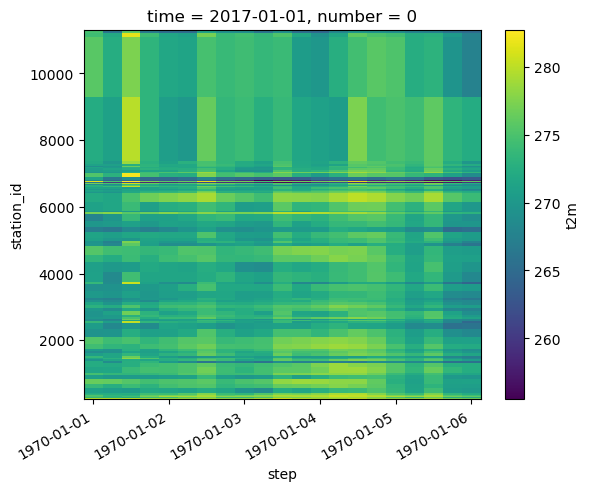

In [18]:
check_1.isel(time = 0, number = 0).plot()

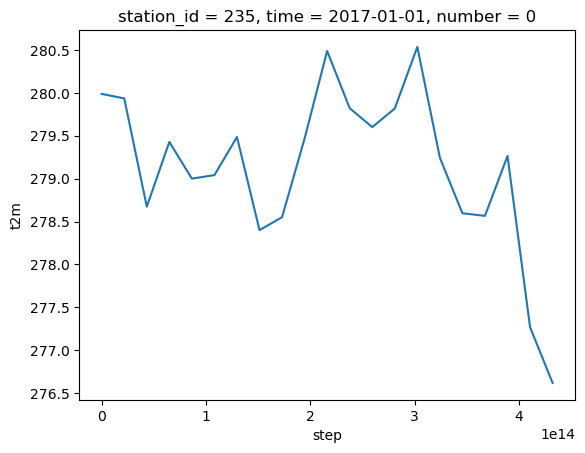

In [19]:
check_saved_file.isel( time = 0, number = 0, station_id=0).plot()

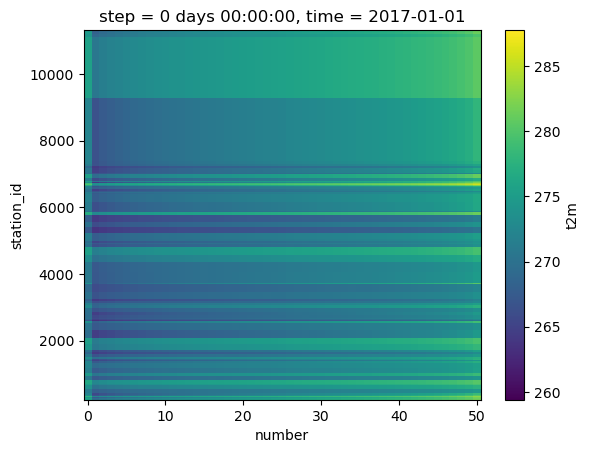

In [20]:
check_saved_file.isel( time = 0,  step = 0).plot()